# Choose the CPU cores number you want to use

In [1]:
import ray
ray.init(num_cpus=50, num_gpus=1)

2020-11-15 15:14:03,986	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '128.10.130.25',
 'raylet_ip_address': '128.10.130.25',
 'redis_address': '128.10.130.25:25962',
 'object_store_address': '/tmp/ray/session_2020-11-15_15-14-02_406565_9328/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-15_15-14-02_406565_9328/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2020-11-15_15-14-02_406565_9328',
 'metrics_export_port': 62132}

# Prepare

In [2]:
import CoRec
import gym
import numpy as np

import stable_baselines
from stable_baselines import ACKTR
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from ray import tune

W1115 15:14:10.307549 139798508054336 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Reward is simply set as the number of safe steps

In [3]:
class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reward(self, r):
        if r <= -1:
            r = 0
        else:
            r += 0.1

        return r

# Hyper-parameters Range

In [4]:
def acktr_hyper(**kwargs): return kwargs

config = acktr_hyper(
    gamma=tune.uniform(0.95, 1),  
    n_steps=tune.choice([256, 512, 1024, 2048, 4096]), 
    ent_coef=0.05, 
    vf_coef=tune.uniform(0.2, 0.8), 
    vf_fisher_coef=tune.uniform(0.5, 1.0), 
    learning_rate=tune.loguniform(1e-6, 0.01), 
    max_grad_norm=0.5, 
    kfac_clip=tune.loguniform(0.001, 0.1), 
    lr_schedule='linear', 
    kfac_update=1, 
    gae_lambda=tune.uniform(0.95, 0.999), 
    seed=1
)
    
config

{'gamma': <ray.tune.sample.Float at 0x7f1460612d30>,
 'n_steps': <ray.tune.sample.Categorical at 0x7f1460612da0>,
 'ent_coef': 0.05,
 'vf_coef': <ray.tune.sample.Float at 0x7f1460612e10>,
 'vf_fisher_coef': <ray.tune.sample.Float at 0x7f1460612e80>,
 'learning_rate': <ray.tune.sample.Float at 0x7f1460612ef0>,
 'max_grad_norm': 0.5,
 'kfac_clip': <ray.tune.sample.Float at 0x7f1460612f60>,
 'lr_schedule': 'linear',
 'kfac_update': 1,
 'gae_lambda': <ray.tune.sample.Float at 0x7f1460612fd0>,
 'seed': 1}

# Train
Error can happen because numerical instability in the model itself.

In [5]:
def env_func(): return RewardWrapper(gym.make("F16GCAS-v3"))
env = make_vec_env(env_func, n_envs=4)

In [6]:
class ReportCallback(stable_baselines.common.callbacks.BaseCallback):
    def __init__(self, verbose=0):
        super(ReportCallback, self).__init__(verbose)
        
    def _on_rollout_end(self) -> None:
        ep_rewards = [ep_info["r"] for ep_info in self.model.ep_info_buf]
        ep_rew_mean = np.mean(ep_rewards)
        tune.report(ep_rew = ep_rew_mean)
    
    def _on_step(self) -> bool:
        return True
    
def F16_acktr(config):
    callback = ReportCallback()
    model = ACKTR(MlpPolicy, env, verbose=1, **config)
    model.learn(total_timesteps=250000, callback=callback)
    model.save("acktr_f16")

# conc_conf = {}
# for k, v in config.items():
#     try:
#         conc = v.sample()
#         conc_conf[k] = conc
#     except:
#         conc_conf[k] = v
# conc_conf
# F16_acktr(conc_conf)
analysis = tune.run(F16_acktr, config=config, num_samples=50, verbose=1, metric="ep_rew", mode="max", raise_on_failed_trial=False)

Trial name,status,loc,gae_lambda,gamma,kfac_clip,learning_rate,n_steps,vf_coef,vf_fisher_coef,iter,total time (s),ep_rew
F16_acktr_20455_00000,TERMINATED,,0.994592,0.955938,0.00142601,4.21522e-06,2048,0.611083,0.76803,30,302.132,63.2816
F16_acktr_20455_00001,TERMINATED,,0.973419,0.999755,0.00187411,2.30619e-05,4096,0.585028,0.573355,15,287.616,62.2311
F16_acktr_20455_00002,TERMINATED,,0.966543,0.987002,0.0046456,0.0041241,256,0.703296,0.870686,244,306.745,62.0286
F16_acktr_20455_00003,TERMINATED,,0.951569,0.95473,0.00477052,0.00596806,2048,0.469984,0.67567,30,287.532,61.7891
F16_acktr_20455_00004,TERMINATED,,0.98537,0.978992,0.00142601,0.00189921,4096,0.676859,0.717412,15,302.988,63.612
F16_acktr_20455_00005,TERMINATED,,0.9593,0.962507,0.0819595,3.97567e-05,1024,0.734368,0.990944,61,306.161,62.1528
F16_acktr_20455_00006,TERMINATED,,0.981855,0.951895,0.00145933,2.21564e-05,512,0.425808,0.613797,122,291.708,61.9886
F16_acktr_20455_00007,TERMINATED,,0.993271,0.983769,0.00112133,0.0005695,1024,0.614511,0.943013,61,290.898,63.5015
F16_acktr_20455_00008,TERMINATED,,0.995103,0.99309,0.0203395,3.137e-05,2048,0.601284,0.720048,30,286.343,62.0147
F16_acktr_20455_00009,TERMINATED,,0.959903,0.991949,0.00908158,0.000363437,256,0.627735,0.618242,244,308.347,60.8361


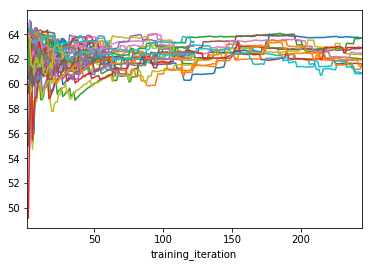

In [7]:
ax = None
dfs = analysis.trial_dataframes
for d in dfs.values():
    ax = d.plot("training_iteration", "ep_rew", ax=ax, legend=False)

In [26]:
import seaborn as sns
import pandas as pd

new_frame = []
for d in dfs.values():
    new_frame.append(pd.concat([d["training_iteration"], d["ep_rew"]], axis=1))

new_frame = pd.concat(new_frame, axis=0)
new_frame.insert(2, "algo", "acktr")
new_frame.to_csv("rl_train_res/acktr.csv")
new_frame.head()

,training_iteration,ep_rew,algo
0,1,NaN,acktr
1,2,60.398504,acktr
2,3,62.431451,acktr
3,4,61.796993,acktr
4,5,62.304875,acktr


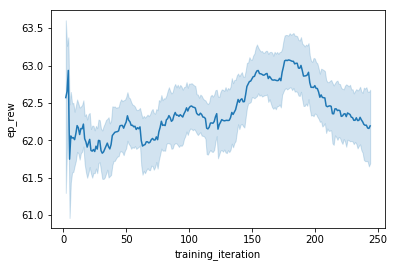

In [20]:
sns.lineplot(data=new_frame, x="training_iteration", y="ep_rew")

In [8]:
analysis.get_best_config(metric="ep_rew", mode="max")

{'gamma': 0.999497992632807,
 'n_steps': 256,
 'ent_coef': 0.05,
 'vf_coef': 0.4262874785955009,
 'vf_fisher_coef': 0.6477845775377029,
 'learning_rate': 4.75099352083847e-05,
 'max_grad_norm': 0.5,
 'kfac_clip': 0.0029536175122031228,
 'lr_schedule': 'linear',
 'kfac_update': 1,
 'gae_lambda': 0.9849241727107956,
 'seed': 1}

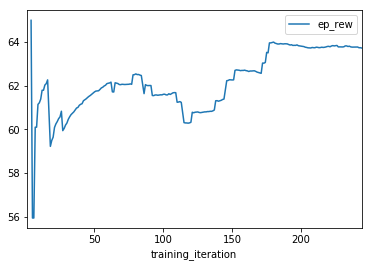

In [9]:
analysis.best_dataframe.plot("training_iteration", "ep_rew")